In [1]:
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [4]:
# Create data
X, y = make_moons(n_samples=10_000, noise=0.25)
data = np.hstack((X, y.reshape(-1, 1)))

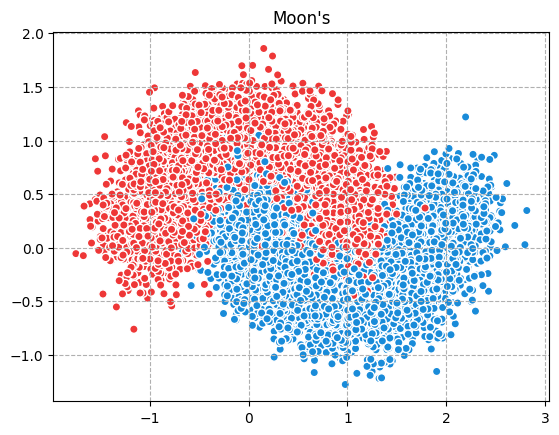

In [5]:
# Visualization
cmap_ = ListedColormap(['#ee3737', '#198bd9'])

fig, ax = plt.subplots()
ax.scatter(x=data[:, 0], y=data[:, 1], c=data[:, 2], cmap=cmap_, edgecolors='white')
ax.set_title("Moon's")
plt.grid(True, linestyle='dashed')
plt.show()

In [6]:
# np to torch.tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [7]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.3,
    shuffle=True
)

In [8]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [9]:
print('Train Dataset:', train_dataset[0])
print('Test Dataset:', test_dataset[0])

Train Dataset: (tensor([1.1156, 0.8435]), tensor(0.))
Test Dataset: (tensor([ 0.5799, -0.4433]), tensor(1.))


In [10]:
N = 64  # Batch Size
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=N) 
test_loader = DataLoader(test_dataset, batch_size=N)

In [11]:
# model configs
IN = 2
HIDDEN = 4
OUT = 1

In [12]:
import torch.nn.init as init  # Correctly importing the init module

class MoonClassifier(nn.Module):
    def __init__(
        self,
        input_layer: int = 2,  # Replace with your actual input dimension
        hidden_layer: int = 16,  # Replace with your actual hidden layer dimension
        output_layer: int = 1  # Replace with your actual output dimension
    ):
        super().__init__()
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.net = nn.Sequential(
            nn.Linear(self.input_layer, self.hidden_layer),
            nn.Mish(),
            nn.Linear(self.hidden_layer, self.output_layer)
        )
        self.output = nn.Sigmoid()
        
        # Apply He initialization to the layers
        self._initialize_weights()
        
    def forward(self, x):
        x = self.net(x)
        x = self.output(x)
        return x
    
    def _initialize_weights(self):
        # Initialize weights using He initialization (Kaiming initialization)
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                init.kaiming_normal_(layer.weight, nonlinearity='relu')  # Use 'relu' even for Mish
                if layer.bias is not None:
                    init.zeros_(layer.bias)

In [13]:
model = MoonClassifier()

In [14]:
summary(model, verbose=2)

Layer (type:depth-idx)                   Param #
MoonClassifier                           --
├─Sequential: 1-1                        --
│    └─0.weight                          ├─32
│    └─0.bias                            ├─16
│    └─2.weight                          ├─16
│    └─2.bias                            └─1
│    └─Linear: 2-1                       48
│    │    └─weight                       ├─32
│    │    └─bias                         └─16
│    └─Mish: 2-2                         --
│    └─Linear: 2-3                       17
│    │    └─weight                       ├─16
│    │    └─bias                         └─1
├─Sigmoid: 1-2                           --
Total params: 65
Trainable params: 65
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
MoonClassifier                           --
├─Sequential: 1-1                        --
│    └─0.weight                          ├─32
│    └─0.bias                            ├─16
│    └─2.weight                          ├─16
│    └─2.bias                            └─1
│    └─Linear: 2-1                       48
│    │    └─weight                       ├─32
│    │    └─bias                         └─16
│    └─Mish: 2-2                         --
│    └─Linear: 2-3                       17
│    │    └─weight                       ├─16
│    │    └─bias                         └─1
├─Sigmoid: 1-2                           --
Total params: 65
Trainable params: 65
Non-trainable params: 0

In [15]:
LR = 0.1  # Learning Rate
EPOCHS = 20
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

In [16]:
metrics = defaultdict(list)

In [17]:
def training_loop(
        model,
        data_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler
    ) -> tuple[float]:
    # puts the model into training mode
    model.train()
    accuracy = Accuracy(task="binary")
    running_loss = 0.0
    running_acc = 0.0
    for i, (X, y) in enumerate(data_loader):
        # forward
        y_hat = model(X)
        y = y.unsqueeze(1)
        loss = criterion(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # y_hat = torch.round(y_hat)
        acc = accuracy(y_hat, y).item()

        running_loss += loss.item()
        running_acc += acc

    avg_loss = running_loss / len(data_loader)
    avg_acc = running_acc / len(data_loader)
    
    return avg_loss, avg_acc

@torch.no_grad
def test_looping(model, data_loader, criterion=criterion):
    model.eval()

    accuracy = Accuracy(task="binary")
    running_loss = 0.0
    running_acc = 0.0
    for i, (X, y) in enumerate(data_loader):
        y_hat = model(X)
        y = y.unsqueeze(1)
        # y_hat = torch.round(y_hat)
        loss = F.binary_cross_entropy(y_hat, y).item()
        acc = accuracy(y_hat, y).item()
        
        running_loss += loss
        running_acc += acc

    avg_loss = running_loss / len(data_loader)
    avg_acc = running_acc / len(data_loader)
    return avg_loss, avg_acc

In [18]:
progress_bar = tqdm(range(EPOCHS), desc="Training Progress")

metrics = defaultdict(list)

for epoch in progress_bar:
    train_loss, train_acc = training_loop(model, train_loader)
    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)

    test_loss, test_acc = test_looping(model, test_loader)
    metrics['test_loss'].append(test_loss)
    metrics['test_acc'].append(test_acc)
    progress_bar.set_description(
        f"Epoch {epoch+1}/{EPOCHS} |"
        f"[Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}] |"
        f"[Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}]"
    )

Epoch 20/20 |[Train Loss: 0.1535, Test Loss: 0.1515] |[Train Acc: 0.9387, Test Acc: 0.9421]: 100%|██████████| 20/20 [00:02<00:00,  7.30it/s]


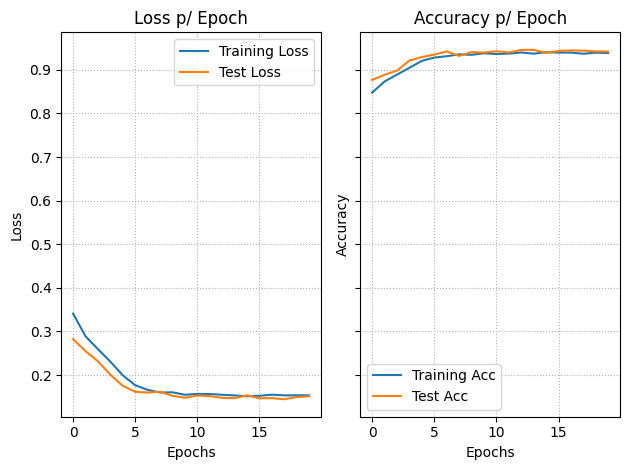

In [19]:
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(metrics['train_loss'], label='Training Loss')
axs[0].plot(metrics['test_loss'], label='Test Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss p/ Epoch')
axs[0].legend()
axs[0].grid(True, linestyle='dotted')

axs[1].plot(metrics['train_acc'], label='Training Acc')
axs[1].plot(metrics['test_acc'], label='Test Acc')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy p/ Epoch')
axs[1].legend()
axs[1].grid(True, linestyle='dotted')

plt.tight_layout()
plt.show()